In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats

In [2]:
df_scrutin = pd.read_csv('database_scrutins.csv', index_col = 'idScrutin')

In [3]:
df_scrutin[df_scrutin['resultat'].isin(['adopté'])].count()*100/df_scrutin.count()

Unnamed: 0                 27.701186
date_scrutin               27.701186
code_type_vote             27.701186
titre                      27.701186
demandeur                  27.754578
organe_ref                 27.701186
votants                    27.701186
pour                       27.701186
contre                     27.701186
non_votants                27.701186
non_votants_volontaires    27.701186
abstention                 27.701186
resultat                   27.701186
dtype: float64

27,7% des scrutin soumis au vote ont été adoptés 

In [4]:
df_scrutin['abstention'].mean()

5.015389547932029

Il y a en moyenne 5 abstentions par scrutin

On crée le ratioabstention : nombre d'abstention/nombre de votants

In [5]:
df_scrutin['ratioabstention'] = df_scrutin['abstention']/df_scrutin['votants']
df_scrutin['ratioabstention'].describe()

count    3119.000000
mean        0.047309
std         0.051349
min         0.000000
25%         0.009390
50%         0.032000
75%         0.067797
max         0.445783
Name: ratioabstention, dtype: float64

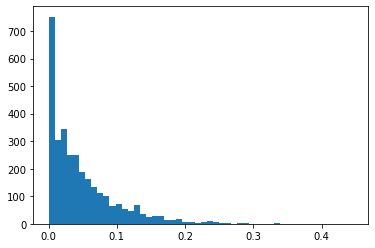

In [6]:
z = plt.hist(df_scrutin['ratioabstention'], bins = 50)

On récupère les "points" de l'histogramme pour pouvoir ploter la distribution de ratioabstention 

In [7]:
x = z[1][1:]
y = z[0]
y1 = []
x1 = []
for i in range(len(y)):
    if y[i] != 0:
        y1.append(y[i])
        x1.append(x[i])

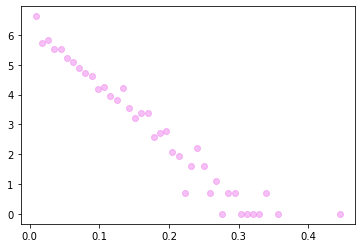

In [16]:
#x et log y
plt.plot(x1,np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')

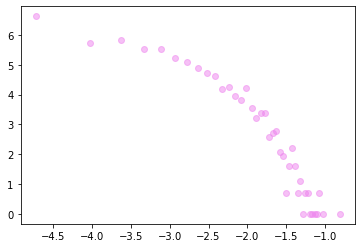

In [8]:
#log x et log y
plt.plot(np.log(x1),np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')

Le premier plot s'approche beaucoup d'une droite, contrairement au second. On pense alors à une loi exponentielle plutôt qu'à une loi de puissance. On fait une régression linéaire de log(effectifs) sur le ratio pour s'assurer qu'on a bien une droite. 

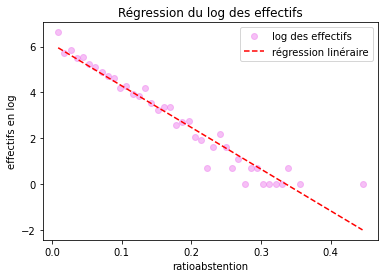

In [9]:
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(x1,np.log(y1))

plt.plot(x1,np.log(y1), 'o', color = 'violet', alpha = 0.5, label = 'log des effectifs')
plt.plot(x1,[i*slope + intercept for i in x1], color = 'red', linestyle = 'dashed', label = 'régression linéraire')
plt.ylabel('effectifs en log')
plt.xlabel('ratioabstention')
plt.title('Régression du log des effectifs')
plt.legend()

On repasse à l'exponentielle pour comparer les distributions 

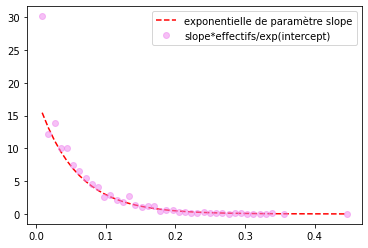

In [10]:
#exponentielle à partir des x1
liste = list(stats.expon.pdf(x1, scale = -1/slope))
plt.plot(x1, liste,color = 'red',linestyle = 'dashed', label = 'exponentielle de paramètre slope')
b = int(np.exp(intercept))
a = int(slope)
y2 = [(-a/b)*i for i in y1]
plt.plot(x1,y2, 'o', color = 'violet', alpha = 0.5, label = 'slope*effectifs/exp(intercept)')
plt.legend()

C'est la variable **slope*effectifs/exp(intercept)** qui suit une **loi exponentielle** de paramètre(-slope). Donc **y1 c'est à dire les effectifs en fonction du ratioabstention est proportionnel à une loi exponentielle de paramètre (-slope)**.

On fait un KS test pour vérifier : on fait le test en repartant des données brutes. Hyp nulle = les deux distributions sont les mêmes.

In [11]:
df_scrutin['ratioabstention'].std() # = 0.05134890024774486
df_scrutin['ratioabstention'].mean() # = 0.04730943735076457
1/(-slope) # = 0.05508338038440398

0.05508338038440398

Ca correspond bien à notre hypothèse d'une loi exponentielle de paramètre (-slope) puisque l'espérance et la variance de nos données sont proches de 1/(-slope).

On génère des données selon une loi exponentielle de paramètre (-slope).

In [18]:
t = np.random.exponential(scale=(-1/slope), size = 100) #scale = 1/lambda

In [19]:
t.mean()

0.05565391247577806

In [20]:
stats.ks_2samp(df_scrutin['ratioabstention'], np.random.exponential(scale=(-1/slope), size = 100))

KstestResult(statistic=0.20359089451747356, pvalue=0.0005341632197694013)

On a une statistique de test très proche de 1 et une p-value = 0. c'est l'inverse de ce qu'on veut montrer car ça montre que les données ne suivent pas une loi exponentielle.

On essaye avec la loi de puissance : y1/exp(intercept) ne suis pas une loi de puissance de paramètre (-slope).

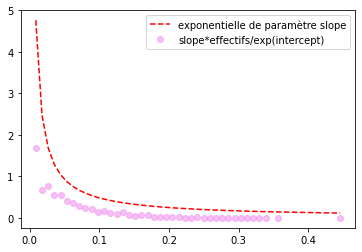

In [29]:
#powerlaw à partir des x1
liste = list(stats.powerlaw.pdf(x1,-1/slope))
plt.plot(x1, liste,color = 'red',linestyle = 'dashed', label = 'exponentielle de paramètre slope')
b = int(np.exp(intercept))
y3 = [(1/b)*i for i in y1]
plt.plot(x1,y3, 'o', color = 'violet', alpha = 0.5, label = 'slope*effectifs/exp(intercept)')
plt.legend()

**Groupes en fonction de l'abstention**

moyenne à 4,6% et 3ème quartile à 6,7% => le max est vraiment très max donc apparemment certains scrutins ont eu une très forte absention par rapport aux autres -> on va essayer de regarder ces valeurs extrêmes

On choisit 97% comme seuil pour séparer les données en fonction du ratio abstention, cf queue épaisse de la loi exponentielle. On veut rendre compte des valeurs extrêmes et ne pas les noyer dans les valeurs moyennes, dans la mesure où les valeurs extrêmes sont très extrêmes. On veut pouvoir leur donner un sens. 

In [45]:
seuil = df_scrutin['ratioabstention'].quantile(q = [0.97])

In [31]:
df_scrutin0 = df_scrutin[df_scrutin['ratioabstention'].isin([0])]
df_scrutin1 = df_scrutin[(df_scrutin['ratioabstention'] >0) & (df_scrutin['ratioabstention']< seuil)]
df_scrutin2 = df_scrutin[df_scrutin['ratioabstention'] >= seuil]

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention nulle')

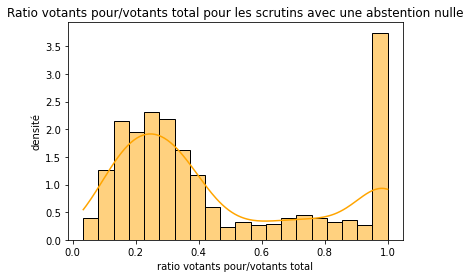

In [32]:
pourcentagepourdf0 = df_scrutin0['pour']/df_scrutin0['votants']
sns.histplot(pourcentagepourdf0,color = 'orange', stat = 'density', bins = 20,kde = True)
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('densité')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention nulle")

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention moyenne')

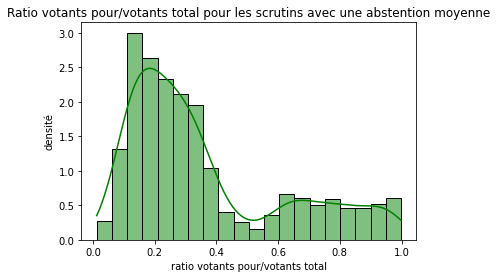

In [33]:
pourcentagepourdf1 = df_scrutin1['pour']/df_scrutin1['votants']
sns.histplot(pourcentagepourdf1,color = 'green', stat = 'density', bins = 20,kde = True)
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('densité')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention moyenne")

Text(0.5, 1.0, 'Ratio votants pour/votants total pour les scrutins avec une abstention forte')

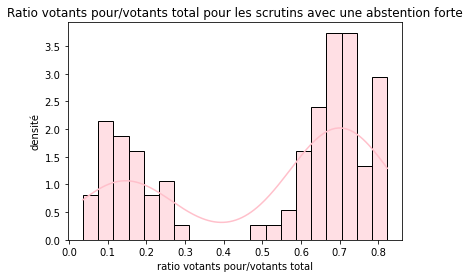

In [34]:
pourcentagepourdf2 = df_scrutin2['pour']/df_scrutin2['votants']
sns.histplot(pourcentagepourdf2,color = 'pink', stat = 'density', bins = 20,kde = True)
plt.xlabel('ratio votants pour/votants total')
plt.ylabel('densité')
plt.title("Ratio votants pour/votants total pour les scrutins avec une abstention forte")

**Test statistique : KS pour tester l'égalité des distributions**

The D statistic is the absolute max distance (supremum) between the CDFs of the two samples. The closer this number is to 0 the more likely it is that the two samples were drawn from the same distribution.
The p-value returned by the k-s test has the same interpretation as other p-values. You reject the null hypothesis that the two samples were drawn from the same distribution if the p-value is less than your significance level.


In [35]:
stats.ks_2samp(pourcentagepourdf2,pourcentagepourdf1)

KstestResult(statistic=0.41954131876363154, pvalue=5.440092820663267e-15)

In [36]:
stats.ks_2samp(pourcentagepourdf0,pourcentagepourdf1)

KstestResult(statistic=0.1577406947195644, pvalue=2.2861379456173836e-11)

In [37]:
stats.ks_2samp(pourcentagepourdf0,pourcentagepourdf2)

KstestResult(statistic=0.3292996270203067, pvalue=1.8096952381085885e-08)

On a des p-values très faibles, inférieures à tous les seuils de significativité usuels : pour chaque test on rejette l'hypothèse nulle selon laquelle les distributions sont les mêmes. 

**Histogramme normé**

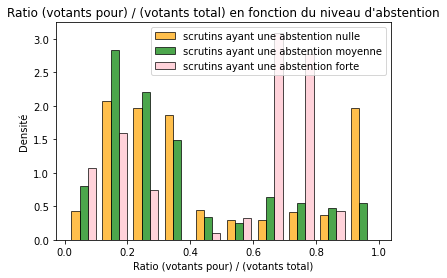

In [51]:
plt.hist([pourcentagepourdf0, pourcentagepourdf1, pourcentagepourdf2], edgecolor = 'black', color = ['orange', 'green', 'pink'], alpha = 0.7,
            histtype = 'bar', label = ['scrutins ayant une abstention nulle', 'scrutins ayant une abstention moyenne', 'scrutins ayant une abstention forte'], density = True) 
plt.xlabel('Ratio (votants pour) / (votants total)')
plt.ylabel('Densité')
plt.title("Ratio (votants pour) / (votants total) en fonction du niveau d'abstention")
plt.legend()
plt.savefig('hist.png')

<AxesSubplot:ylabel='Count'>

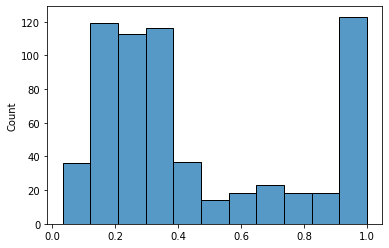

In [42]:
sns.histplot(pourcentagepourdf0, multiple = 'dodge')

Si les distributions orange et verte (abstention moyenne et nulle) se ressemblent, on voit que la distrubtion rose (abstention forte) diffère (quasiment en symétrique). Les scrutins où l'abstention est très forte sont des scrutins où les votes sont très consensuels : plus des 3/4 des scrutins sont adoptés avec plus de 60% de vote pour. A l'inverse, lorsque l'abstention est moyenne ou nulle, les scrutins sont moins souvent adoptés (les votes pour ne dépassent pas les 40% pour les 2/3 des scrutins), sauf une exeption pour la denière barre orange (à expliquer mieux). 


**Courbes pas utiles**

Dans le cas où l'abstention est nulle on a presque l'inverse de la courbe pour l'abstention forte -> les votes contre sont majoritaires (votes pour <40%) pour les 2/3 des scrutins (on peut le lire comme ça car les abstentions sont nulles donc les votes non pour sont des votes contre) => idée que les députés se mobilisent plus (et donc s'abtstiennent moins) pour les scrutins avec lesquels ils sont en désaccord ? Il faudrait voir la nature de ces scrutins et voir les caractéristiques des votants qui font "barrage"